In [18]:
from glob import glob
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
benchmark_dir = "/Users/pwalters/software/ts_benchmark/"

In [20]:
def read_ref_df(filename):
    ref_df = pd.read_csv(filename).sort_values("score",ascending=False)
    top_100_names = set(ref_df.head(100).name.values)
    top_1000_names = set(ref_df.head(1000).name.values)
    return top_100_names, top_1000_names

def read_logfile(filename):
    with open(filename) as ifs:
        lines = ifs.readlines()
        return int(lines[-2].split()[3])

def count_hits(df_in,top_100, top_1000):
    hit_count = 1
    hit_list = []
    for idx,name in enumerate(df_in.Name.values):
        if name in top_1000:
            hit_list.append([idx,hit_count])
            hit_count += 1
    df_in.sort_values("score",ascending=False,inplace=True)
    top_100_scores = df_in.score.values[:100]
    top_1000_scores = df_in.score.values[:1000]
    df_in.drop_duplicates("Name",inplace=True)
    num_hits_100 = len(df_in.query("Name in @top_100"))
    num_hits_1000 = len(df_in.query("Name in @top_1000"))
    return num_hits_100, num_hits_1000, hit_list, top_100_scores, top_1000_scores
    
def get_scores(dirname):
    os.chdir(dirname)
    df_list = []
    for filename in glob("*logs*0*.csv"):
        method, libname, target, _, cycle = filename.split("_")
        cycle = int(cycle.split(".")[0])
        df = pd.read_csv(filename)
        df_100 = df.sort_values("score",ascending=False).head(100).copy()  
        df_100['method'] = method
        df_100['libname'] = libname
        df_100['target'] = target
        df_100['cycle'] = cycle
        df_list.append(df_100)
    os.chdir("..")
    return df_list

In [21]:
ref_dict = {}
for dirname in ["docking","rocs"]:
    for libname in ["amide","quinazoline"]:
        ref_dict[f"{libname}_{dirname}"] = read_ref_df(f"{dirname}/{libname}_{dirname}_scores.csv") 

In [22]:
os.chdir(benchmark_dir)
docking_combo_df = pd.concat(get_scores("docking"))
docking_combo_df.reset_index(inplace=True)

In [23]:
docking_combo_df.query("method == 'ga'").libname.value_counts()

libname
quinazoline    1000
amide          1000
Name: count, dtype: int64

In [24]:
method_order = ["rws","ts"]

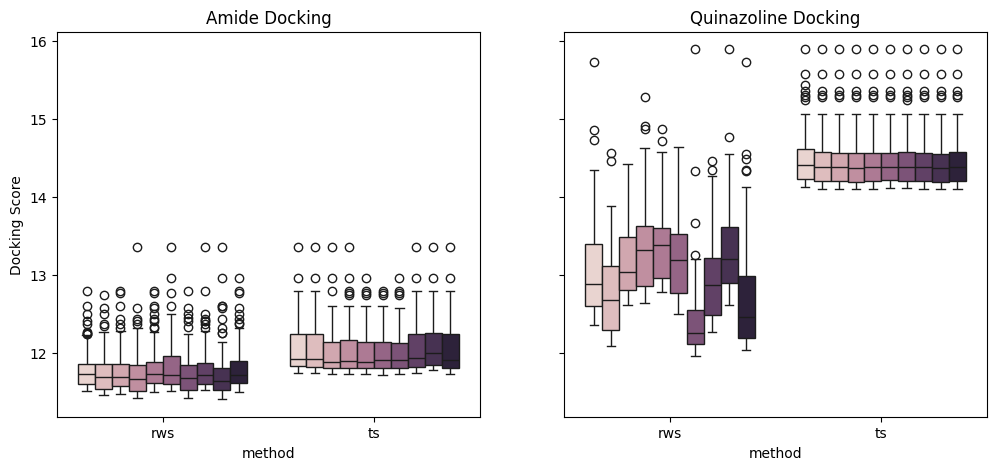

In [25]:
figure, axes = plt.subplots(1,2,figsize=(12,5),sharey=True)
ax0 = sns.boxplot(x="method",y="score",hue="cycle",data=docking_combo_df.query("libname == 'amide'"),legend=None,order=method_order,ax=axes[0])
ax0.set_ylabel("Docking Score")
ax0.set_title("Amide Docking")
ax1 = sns.boxplot(x="method",y="score",hue="cycle",data=docking_combo_df.query("libname == 'quinazoline'"),legend=None,order=method_order,ax=axes[1])
ax1.set_ylabel("Docking Score")
ax1.set_title("Quinazoline Docking");

In [26]:
ref_dict.keys()

dict_keys(['amide_docking', 'quinazoline_docking', 'amide_rocs', 'quinazoline_rocs'])

In [27]:
docking_result_list = []
for k,v in docking_combo_df.groupby(["method","libname","cycle"]):
    method, libname, cycle = k
    key_name = f"{libname}_docking"
    top_100_list = ref_dict[key_name][0]
    docking_result_list.append([method, libname, cycle, len(v.query("Name in @top_100_list"))])
docking_result_df = pd.DataFrame(docking_result_list,columns=["method","libname","cycle","top_100"])

Text(0.5, 1.0, 'Quinazoline Docking')

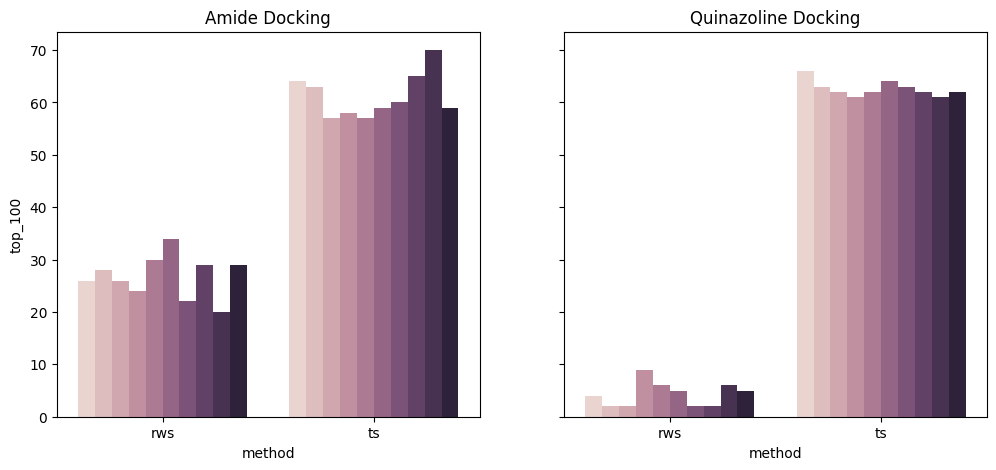

In [28]:
figure, axes = plt.subplots(1,2,figsize=(12,5),sharey=True)
ax0 = sns.barplot(x="method",y="top_100",hue="cycle",data=docking_result_df.query("libname == 'amide'"),legend=None,order=method_order,ax=axes[0])
ax0.set_title("Amide Docking")
ax1 = sns.barplot(x="method",y="top_100",hue="cycle",data=docking_result_df.query("libname == 'quinazoline'"),legend=None,order=method_order,ax=axes[1])
ax1.set_title("Quinazoline Docking")

In [29]:
os.chdir(benchmark_dir)
rocs_combo_df = pd.concat(get_scores("rocs"))
rocs_combo_df.reset_index(inplace=True)

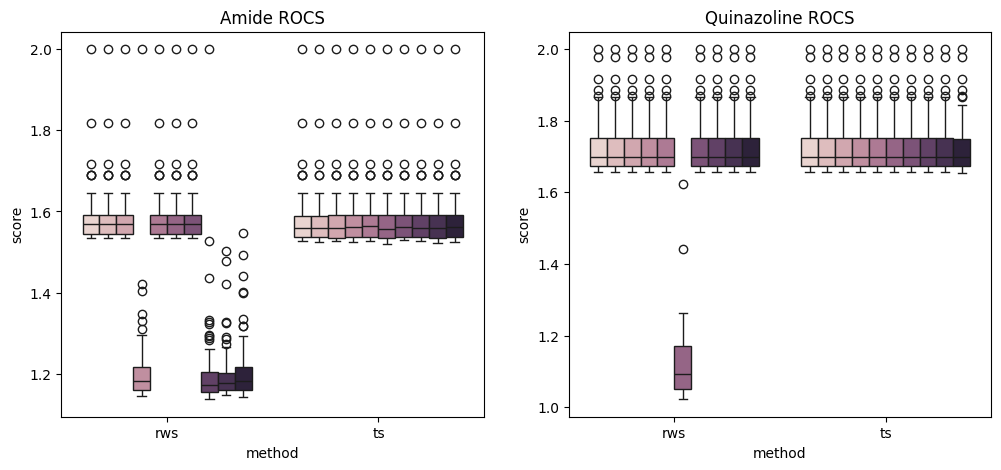

In [30]:
figure, axes = plt.subplots(1,2,figsize=(12,5))
ax0 = sns.boxplot(x="method",y="score",hue="cycle",data=rocs_combo_df.query("libname == 'amide'"),legend=None,order=method_order,ax=axes[0])
ax0.set_title("Amide ROCS")
ax1 = sns.boxplot(x="method",y="score",hue="cycle",data=rocs_combo_df.query("libname == 'quinazoline'"),legend=None,order=method_order,ax=axes[1])
ax1.set_title("Quinazoline ROCS");

In [31]:
rocs_result_list = []
for k,v in rocs_combo_df.groupby(["method","libname","cycle"]):
    method, libname, cycle = k
    key_name = f"{libname}_rocs"
    top_100_list = ref_dict[key_name][0]
    rocs_result_list.append([method, libname, cycle, len(v.query("Name in @top_100_list"))])
rocs_result_df = pd.DataFrame(rocs_result_list,columns=["method","libname","cycle","top_100"])

Text(0.5, 1.0, 'Quinazoline ROCS')

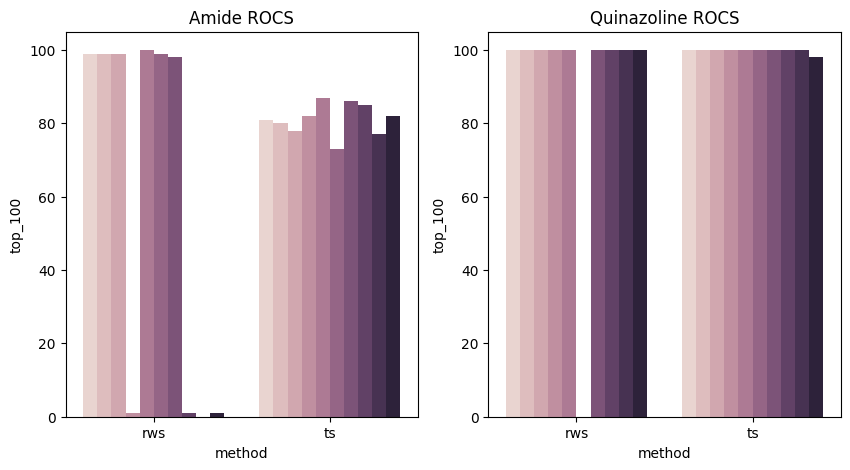

In [32]:
figure, axes = plt.subplots(1,2,figsize=(10,5))
ax0 = sns.barplot(x="method",y="top_100",hue="cycle",data=rocs_result_df.query("libname == 'amide'"),legend=None,ax=axes[0],order=method_order)
ax0.set_title("Amide ROCS")
ax1 = sns.barplot(x="method",y="top_100",hue="cycle",data=rocs_result_df.query("libname == 'quinazoline'"),legend=None,ax=axes[1],order=method_order)
ax1.set_title("Quinazoline ROCS")